### Introduction

This is simply a concise implementation of the model defined in `model.ipynb` using PyTorch's high level APIs instead. This will be much less detailed and future no analyses or graphs.

In [13]:
from d2l import torch as d2l
import pandas as pd
import torch
import os

class BostonHouseData(d2l.DataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.save_hyperparameters()

        file_path = os.path.join("data", "housing.csv")
        data = pd.read_csv(file_path, sep=r"\s+", header=None)

        X = data.iloc[:, :-1].values
        X = (X - X.mean(axis=0)) / X.std(axis=0)

        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float).reshape(-1,1)
        self.num_train_examples = 400

    def get_dataloader(self, train):
        i = slice(0, self.num_train_examples) if train else slice(self.num_train_examples, None)
        return self.get_tensorloader((self.X, self.y), train, i)


In [11]:
from torch import nn

class HouseLinearRegression(d2l.Module):
    def __init__(self, num_features, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Linear(num_features, 1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

In [7]:
import matplotlib.pyplot as plt

class HouseLRTrainer(d2l.HyperParameters):
    def __init__(self, max_epochs):
        self.save_hyperparameters()
        self.training_losses = []
        self.validation_losses = []

    def prepare_data(self, data):
        self.training_data_loader = data.train_dataloader()
        self.validation_data_loader = data.val_dataloader()
        self.num_training_batches = len(self.training_data_loader)
        self.num_validation_batches = len(self.validation_data_loader)

    def prepare_model(self, model):
        model.trainer = self
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optimizer = model.configure_optimizers()
        self.epoch = 0
        self.training_batch_index = 0
        self.validation_batch_index = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
        self.plot_losses()

    def fit_epoch(self):
        self.model.train()
        for X_batch, y_batch in self.training_data_loader:
            loss = self.model.loss(self.model(X_batch), y_batch)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.training_losses.append(loss.item())
            self.training_batch_index += 1
        self.training_batch_index = 0
        if not self.validation_data_loader:
            return
        self.model.eval()
        for batch in self.validation_data_loader:
            l = self.model.loss(self.model(*batch[:-1]), batch[-1])
            self.validation_losses.append(l.item())
            self.validation_batch_index += 1
        self.validation_batch_index = 0

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.training_losses, label='Training Loss')
        if self.validation_losses:
            val_losses_per_epoch = []
            for i in range(self.max_epochs):
                start = i * self.num_validation_batches
                end = (i + 1) * self.num_validation_batches
                epoch_val_loss = sum(self.validation_losses[start:end]) / self.num_validation_batches
                val_losses_per_epoch.append(epoch_val_loss)
            x_val = [(i + 1) * self.num_training_batches for i in range(self.max_epochs)]
            plt.plot(x_val, val_losses_per_epoch, label='Validation Loss', marker='o')
        plt.xlabel('Batch Index')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Batches')
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--')
        plt.show()

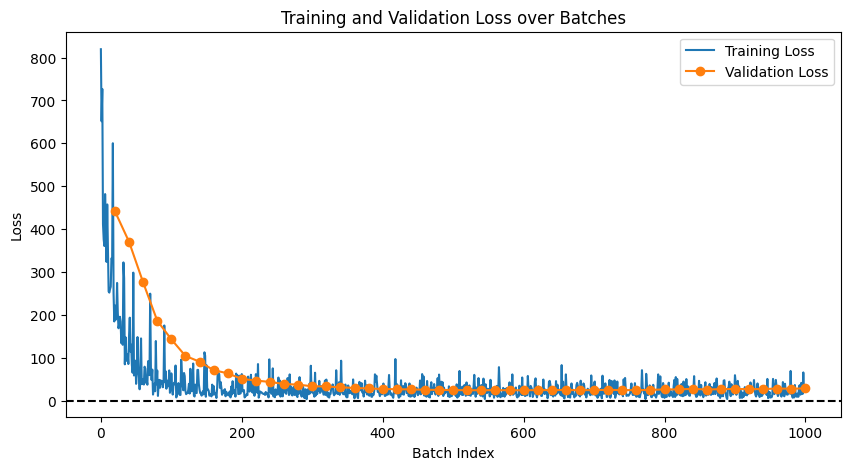

In [14]:
model = HouseLinearRegression(13, lr=0.01)
data = BostonHouseData(20)
trainer = HouseLRTrainer(max_epochs=50)
trainer.fit(model, data)